In [1]:
#importing necessary libraries
import seaborn as sns
color_pal = sns.color_palette()
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime
import datetime
from sklearn.model_selection import TimeSeriesSplit
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import scipy.stats as stats

In [9]:
df = pd.read_csv("WR2018.csv").dropna()
for x in range(2019,2023):
    df = pd.concat([df,pd.read_csv(f"WR{x}.csv").dropna()], axis=0)
df = df[df["FPTS/G"] > 5]
df['YDS'] = df['YDS'].str.replace(',', '').astype(float)
df = df.reset_index()

In [10]:
df.corr()

,index,Rank,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,FL,G,FPTS,FPTS/G
index,1.000000,1.000000,-0.903947,-0.916868,-0.915149,0.030906,-0.411871,-0.755321,-0.739245,-0.215386,-0.207507,-0.119460,-0.215141,-0.772569,-0.934073,-0.725031
Rank,1.000000,1.000000,-0.903947,-0.916868,-0.915149,0.030906,-0.411871,-0.755321,-0.739245,-0.215386,-0.207507,-0.119460,-0.215141,-0.772569,-0.934073,-0.725031
REC,-0.903947,-0.903947,1.000000,0.972332,0.935064,-0.172476,0.269497,0.682960,0.664014,0.180947,0.161563,0.070024,0.240380,0.643698,0.954877,0.790770
TGT,-0.916868,-0.916868,0.972332,1.000000,0.940734,-0.109827,0.313118,0.716861,0.665913,0.164668,0.147162,0.066152,0.224655,0.684239,0.947129,0.758246
YDS,-0.915149,-0.915149,0.935064,0.940734,1.000000,0.105048,0.433979,0.877842,0.734100,0.165385,0.149893,0.088928,0.216774,0.642011,0.977945,0.818220
Y/R,0.030906,0.030906,-0.172476,-0.109827,0.105048,1.000000,0.464641,0.403795,0.123131,-0.075838,-0.067581,-0.009116,-0.052983,-0.064056,0.010809,0.043250
LG,-0.411871,-0.411871,0.269497,0.313118,0.433979,0.464641,1.000000,0.604461,0.394746,0.129482,0.133531,0.058832,0.115807,0.305951,0.396390,0.319577
20+,-0.755321,-0.755321,0.682960,0.716861,0.877842,0.403795,0.604461,1.000000,0.699869,0.170835,0.159124,0.125603,0.146366,0.519479,0.825042,0.701082
TD,-0.739245,-0.739245,0.664014,0.665913,0.734100,0.123131,0.394746,0.699869,1.000000,0.067006,0.050466,0.039054,0.075608,0.460732,0.814087,0.737732
ATT,-0.215386,-0.215386,0.180947,0.164668,0.165385,-0.075838,0.129482,0.170835,0.067006,1.000000,0.915816,0.682564,0.150388,0.171576,0.227481,0.176014


In [11]:

tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
df = df.sort_index()

fold = 0
preds = []
tests = []
scores = []
dates = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train = train
    test = test
    
    FEATURES = ['YDS', "REC", 'TD']
    TARGET = 'FPTS/G'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    dates.append(test["Player"])

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    tests.append(y_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:11.28071	validation_1-rmse:12.66013
[100]	validation_0-rmse:4.57504	validation_1-rmse:5.33615
[200]	validation_0-rmse:2.34489	validation_1-rmse:2.87708
[300]	validation_0-rmse:1.75638	validation_1-rmse:2.28955
[400]	validation_0-rmse:1.60953	validation_1-rmse:2.19230
[500]	validation_0-rmse:1.55238	validation_1-rmse:2.17267
[584]	validation_0-rmse:1.52041	validation_1-rmse:2.16896
[0]	validation_0-rmse:11.47737	validation_1-rmse:9.55836
[100]	validation_0-rmse:4.64730	validation_1-rmse:3.93905
[200]	validation_0-rmse:2.39889	validation_1-rmse:2.44470
[300]	validation_0-rmse:1.82291	validation_1-rmse:2.21467
[400]	validation_0-rmse:1.68159	validation_1-rmse:2.20620
[420]	validation_0-rmse:1.66720	validation_1-rmse:2.20794
[0]	validation_0-rmse:11.26619	validation_1-rmse:10.37072
[100]	validation_0-rmse:4.57429	validation_1-rmse:4.68504
[200]	validation_0-rmse:2.39301	validation_1-rmse:3.15477
[300]	validation_0-rmse:1.84674	validation_1-rmse:2.86878
[386]	validatio

In [16]:
new = pd.read_csv("WR2023.csv").dropna()
new['YDS'] = new['YDS'].str.replace(',', '').astype(float)
new['Prediction'] = reg.predict(new[FEATURES])
new.to_csv("WR-Projections.csv")

% Error Statistics:
count    250.000000
mean      16.997029
std       13.334834
min        0.057001
25%        6.156797
50%       14.067970
75%       25.647908
max       62.101404
Name: % Error, dtype: float64


<AxesSubplot:xlabel='% Error'>

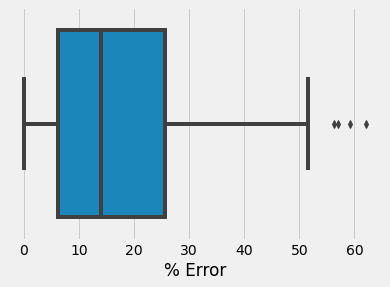

In [17]:
#making csv tracking predictions for each hour and actual results
analysis = pd.DataFrame({'Player': np.concatenate([dates[0], dates[1], dates[2], dates[3], dates[4]]), 'Prediction': np.concatenate([preds[0], preds[1], preds[2], preds[3], preds[4]]), 'Actual': np.concatenate([tests[0].values, tests[1].values, tests[2].values, tests[3].values, tests[4].values])})
analysis["% Error"] = ((analysis["Prediction"]-analysis["Actual"])/analysis["Actual"]).abs()*100
analysis.to_csv('WR-Full_Results.csv')

print("% Error Statistics:")

#printing error metrics, box-plot
print(analysis["% Error"].describe())
sns.boxplot(x=analysis["% Error"])
